# 오버피팅 방지

이 챕터에서는 신경망 모형의 오버피팅을 방지하기 위한 방법들을 다룹니다. 다루는 목록은 아래와 같습니다
- Dropout
- Batch Normalization
- Activation Function
- Initialization
- Optimizer

In [1]:
# module import
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [ ]:
batch_size = 32
epoch = 10
DEVICE = 'cpu'

train_dataset = datasets.MNIST(root = "../data/MNIST",
                              train = True,
                              download = True,
                              transform = transforms.ToTensor())

test_dataset = datasets.MNIST(root = '../data/MNIST',
                             train = False,
                             download = True,
                             transform = transforms.ToTensor())

# 미니 배치(32개 배치) 단위로 묶음
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                          batch_size = batch_size,
                                          shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                         batch_size = batch_size,
                                         shuffle = True)

In [23]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data/MNIST
    Split: Train
    StandardTransform
Transform: ToTensor()

## Dropout
드랍아웃은 신경망 모형에서 데이터를 다음 레이어로 전달할 때, 각 레이어의 노드를 임의로 선택하여 전달하지 않는 과적합 방지 기법이다. 이때 얼마나 많은 노드를 사용하지 않을지는 확률 값을 통해 지정되며, 각 에포크마다 드랍아웃은 독립적으로 적용된다.

In [9]:
class NetDropout(nn.Module): # nn.Module method 상속 -> nn.Module 내의 함수를 Net class 안에서 이용가능함
    
    # 초기화
    def __init__(self):
        super(NetDropout, self).__init__()
        # Fully Connected Layer
        self.fc1 = nn.Linear(28 * 28, 512) # 처음 input layer의 노드수 = 가로*세로*채널수 
        self.fc2 = nn.Linear(512, 256) 
        self.fc3 = nn.Linear(256, 10) # Output : 0~9까지의 이미지 label -> 10개 // Loss를 계산하기 위해서 개수 똑같이 맞춰야 함
        # 드랍아웃 확률 지정
        self.dropout_prob = .5
        
    # 순전파
    def forward(self, x):
        x = x.view(-1, 28*28) # MLP 모델은 1차원 데이터를 입력 받음. 기존 데이터는 (28, 28)의 2차원 데이터이므로 view를 이용하여 28*28개의 1차원 데이터로 변환
        x = self.fc1(x)
        x = F.sigmoid(x)
        # 드랍아웃 추가 후 다음 레이어로 전달
        x = F.dropout(x, training = self.training, p = self.dropout_prob) # self.training은 T/F 값을 가짐. model이 train상태인지 test상태인지에 따라 각각 True와 False가 됨.
        x = self.fc2(x)
        x = F.sigmoid(x)        
        # 드랍아웃 추가 후 다음 레이어로 전달
        x = F.dropout(x, training = self.training, p = self.dropout_prob) # self.training은 T/F 값을 가짐. model이 train상태인지 test상태인지에 따라 각각 True와 False가 됨.
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        return x

model = NetDropout().to(DEVICE)

## Activation
<p>
위 신경망 모형에서는 기본적으로 시그모이드를 활성화 함수로 사용했다. 하지만 시그모이드 함수의 도함수의 최댓값은 1/2로 역전파 시에 기울기 소실 문제가 발생함. 이는 레이어가 많아질수록 더욱 심해지며 오차를 제대로 반영하지 못하는 결과를 냄. 이 문제를 해결하기 위한 다른 함수로 ReLU 활성화 함수를 사용할 수 있음.  
<p>
ReLU함수는 lamp함수의 특별한 case, lamp함수의 최소값이 0, 최대값이 inf인 경우임.

$$ReLU(x) = max(0,x)$$

In [ ]:
class NetActivation(nn.Module):
    
    def __init__(self):
        # Class overriding
        super(NetActivation, self).__init__()
        # Fully Connected Layer
        self.fc1 = nn.Linear(28 * 28 , 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout_prob = .5
        
    def forward(self, x):
        x = x.view(-1, 28*28) # 넘파이의 reshape와 같은 역할. 텐서에 적용하는 reshape라고 생각하면 됨.
        x = self.fc1(x)
        # 활성화 함수 변경 (sigmoid -> ReLU)
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc2(x)
        # 활성화 함수 변경 (sigmoid -> ReLU)
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        return x

## Batch Normalization 
신경망에서 과적합과 기울기 소실 문제 외에도 **Internal Covariance Shift**문제가 발생한다.  
**Internal Covariance Shift**란 각 레이어마다 Input 데이터 분포가 달라짐에 따라 학습 속도가 느려지는 현상을 의미한다.  
이를 Batch Normalization(이하 BN)을 통해 Layer의 분포를 정규화를 하여 학습 속도를 빠르게 유지한다.

**참고**
[Batch Normalization](https://wegonnamakeit.tistory.com/47)

### 전반적인 과정

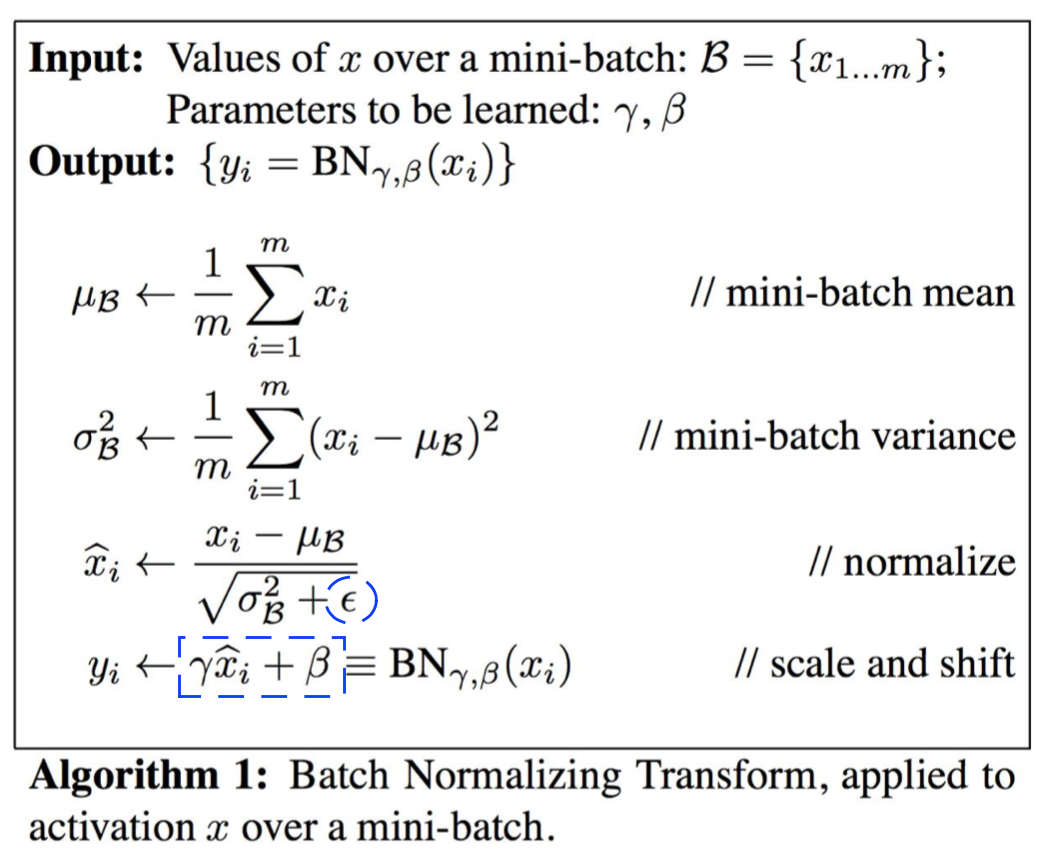

차근차근 설명하면 다음과 같다.
1. input 데이터의 평균을 저장한다.
2. input 데이터의 분산을 저장한다
3. 분산의 약간의 편향을 준 채(NAN이 나오는 것을 방지하기 위함)로 데이터를 정규화한다
4. 파라미터 $\gamma$(scaling) $\beta$ (shift)를 이용해 변환 후 BN을 종료한다.  

이때, 
- input 데이터로는 레이어에 입력되는 데이터가 되며 아웃풋 데이터는 BN을 진행한 데이터이다.
- 학습 과정에서 파라미터 $\gamma$와 $\beta$는 역전파를 통해 업데이트 된다.
- 정규화를 진행하게 되면 활성화 함수의 비선형성을 잃게 되므로 scaling과 shift를 적용함.


$$BN(h; \gamma,\beta) = \beta + \gamma\frac{x_i - \mu_B}{\sqrt{\sigma^2_B + \epsilon}}$$

In [ ]:
class NetBN(nn.Module):
    
    def __init__(self):
        super(NetBN, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout_prob = .5
        # Batch Normalization 지정
        # 1차원 벡터를 이용하기 때문에 1d를 사용
        self.batch_norm1 = nn.BatchNorm1d(512) # 첫번째 layer의 아웃풋 크기가 512개 라서 512        
        self.batch_norm2 = nn.BatchNorm1d(256) # 마찬가지로 256개
    
    """
    BN을 Activation 이전에 적용하는지, 이후에 적용하는지에 대해서는 논문이나 코드에 따라 다르게 적용됨.
    연구자들의 선호도에 따라서도 다르게 적용됨. 여기서는 Activation 이전에 적용.
    """
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        # 활성화 이전에 BN 적용
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        return x

#### Q. Train할 때와 Test할 때 BN은 어떻게 해야하는가?
*내용 보충하기*

## (Weight) Initialization

**참고**
- https://towardsdatascience.com/weight-initialization-techniques-in-neural-networks-26c649eb3b78
- https://www.youtube.com/watch?v=CJB0g_i7pYk

신경망에서는 첫 번째 에포크에서는 이전 손실 함수의 그래디언트의 정보가 없기 때문에 역전파를 통한 파라미터(가중치, 편향) 업데이트가 불가능하다. 그렇기 때문에 가자 확률 분포에 근거하여 초기값을 랜덤으로 설정하였다. 이때 균등분포와 정규분포 두 가지를 사용한다.

**그렇다면 아무런 균등분포나 정규분포를 이용하여 랜덤으로 파라미터를 초기화할 때는 문제가 없을까?**  

*발생한다*. 모든 은닉층의 활성화 함수를 ReLU로, 출력층의 활성화 함수를 sigmoid로 하는 신경망 모형이 있다고 가정하자. 이때 만약 균등분포나 정규분포를 통해 추출한 초기 파라미터의 값이 **1)매우 크거나 2)매우 작다면** 초기 출력층의 값은 **1 또는 0에 매우 근접한 값**이 출력될 것이다. 아래의 sigmoid 그래프를 보면 x=0에서 기울기(미분값)가 최대이며 양 극단으로 갈수록 그 기울기가 감소한다. 따라서 초기 출력층에서의 gradient값은 작게 나올 것이며, 이는 역전파 시에 파라미터 업데이트를 늦추는 문제를 야기한다. 이어서 이는 거듭한 gradient 곱을 통해 기울기 소실 문제를 야기한다.
    


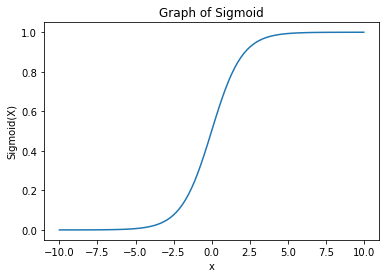

다른 방식으로 생각해보자. 초기 파라미터는 초기 loss function의 시작점을 결정한다. 즉 loss function이 최소값을 찾게하는 시작점을 결정한다. 초기 파라미터에 의한 loss function의 시작점은 학습 속도를 결정짓는 중요한 요인이다. 따라서 이같은 관점에서도 초기 파라미터 설정이 중요하다.

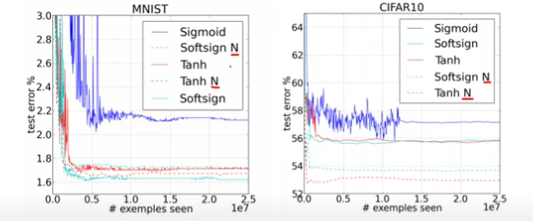

N이 붙은 것들이 weight initialization을 진행한 것인데, error가 많이 감소한 것을 알 수 있다.

**궁금했던 것**  
파이토치의 `nn.Linear`함수가 초기 weight matrix를 구성하는 건 알았는데, 어떤 분포로부터 랜덤하게 설정하는가?
- 기존 `nn.Linear`함수는 Output으로 계산되는 벡터의 차원 수의 역수 값의 절대값 범위 내의 Uniform Distribution으로 부터 랜덤하게 샘플링한다.
- 예를 들어서, hidden layer의 input size는 10, output size가 50이라면, 50x50의 weight matrix와 50x1의 bias vector를 랜덤으로 생성함.
- 즉, $ w_{ij} \sim unif(-\frac{1}{n} ,\frac{1}{n}) $

## 본격적인 initialization

### 1.  Xavier initialzation

- Xavier normal initialization
$$ W \sim N(0,Var(W))\,.$$
$$ Var(W) = \sqrt{\frac{2}{n_{in} + n_{out}}} $$

- Xavier uniform initialization
$$ W \sim U(-\sqrt{\frac{6}{n_{in} + n_{out}}},\sqrt{\frac{6}{n_{in} + n_{out}}})\,.$$


### 코드  실습

In [28]:
# layer 
layer1 = nn.Linear(256, 512)

# 랜덤으로 설정된 것을 알 수 있음
layer1.weight

Parameter containing:
tensor([[-0.0372, -0.0520, -0.0202,  ...,  0.0579,  0.0504,  0.0361],
        [-0.0476, -0.0596,  0.0130,  ..., -0.0083, -0.0208, -0.0511],
        [ 0.0259, -0.0084, -0.0223,  ...,  0.0049,  0.0330,  0.0122],
        ...,
        [ 0.0032,  0.0470,  0.0266,  ..., -0.0582,  0.0163,  0.0467],
        [ 0.0555, -0.0210, -0.0358,  ..., -0.0306, -0.0617,  0.0260],
        [-0.0269, -0.0261, -0.0150,  ..., -0.0543, -0.0531,  0.0511]],
       requires_grad=True)

In [30]:
# Xavier uniform initialization
nn.init.xavier_uniform_(layer1.weight) # 달라졌음. 코드를 실행하는 순간 바로 업데이트 됨.

Parameter containing:
tensor([[ 0.0097, -0.0601, -0.0369,  ...,  0.0312, -0.0474, -0.0101],
        [ 0.0138,  0.0232, -0.0665,  ...,  0.0405, -0.0824, -0.0827],
        [-0.0739,  0.0263,  0.0378,  ..., -0.0732, -0.0871, -0.0184],
        ...,
        [ 0.0743, -0.0704,  0.0019,  ...,  0.0118, -0.0644, -0.0846],
        [ 0.0165, -0.0342, -0.0179,  ...,  0.0133,  0.0751, -0.0483],
        [-0.0018, -0.0511,  0.0423,  ...,  0.0141, -0.0425, -0.0217]],
       requires_grad=True)

In [31]:
layer1 = nn.Linear(256,512)
# Xavier normal initialization
nn.init.xavier_normal_(layer1.weight) # 달라졌음. 코드를 실행하는 순간 바로 업데이트 됨.

Parameter containing:
tensor([[-0.0254,  0.0024, -0.0606,  ...,  0.0255, -0.0278,  0.0507],
        [ 0.0767, -0.0712,  0.0619,  ...,  0.0233,  0.0129,  0.0099],
        [-0.0299, -0.0415, -0.0138,  ..., -0.0048, -0.0007, -0.0710],
        ...,
        [-0.0868,  0.0744, -0.1118,  ..., -0.0408,  0.0914,  0.0625],
        [ 0.0546,  0.0118, -0.0196,  ...,  0.0507,  0.0045, -0.0152],
        [ 0.0017,  0.0707,  0.0278,  ..., -0.0054,  0.0407,  0.0560]],
       requires_grad=True)

### 2.  He initialzation
- modification of Xavier initialization (remove $n_{out}$ term)
- He normal initialization
$$ W \sim N(0,Var(W))\,.$$
$$ Var(W) = \sqrt{\frac{2}{n_{in}}} $$
- He uniform initialization
$$ W \sim U(-\sqrt{\frac{6}{n_{in}}},\sqrt{\frac{6}{n_{in}
}})\,.$$

In [34]:
# He initialization = kaiming in python
layer2 = nn.Linear(256,512)
nn.init.kaiming_uniform_(layer2.weight)

Parameter containing:
tensor([[ 0.0404, -0.0748, -0.0830,  ..., -0.0905,  0.0067, -0.1013],
        [-0.0508, -0.0855, -0.0119,  ..., -0.1180, -0.0951,  0.0824],
        [ 0.0788,  0.1038, -0.1143,  ..., -0.1433,  0.1134,  0.1407],
        ...,
        [ 0.1221, -0.1325,  0.0292,  ...,  0.0516,  0.0670, -0.0870],
        [-0.0873, -0.1067, -0.1435,  ..., -0.1368, -0.0540,  0.0718],
        [ 0.1473, -0.1310, -0.0149,  ...,  0.1250, -0.1309, -0.0346]],
       requires_grad=True)

In [35]:
layer2 = nn.Linear(256,512)
nn.init.kaiming_normal_(layer2.weight)

Parameter containing:
tensor([[ 0.0345, -0.1250,  0.0230,  ...,  0.0551, -0.0928, -0.2267],
        [ 0.1380, -0.2546,  0.0468,  ..., -0.1487,  0.1758, -0.0135],
        [-0.1574,  0.0011,  0.0049,  ...,  0.0242, -0.1085,  0.0578],
        ...,
        [ 0.1635, -0.1370,  0.0814,  ...,  0.1018, -0.0254, -0.0222],
        [ 0.1616,  0.0260, -0.1725,  ..., -0.1554, -0.0245,  0.0008],
        [-0.0278, -0.0910,  0.0003,  ...,  0.0369, -0.0361,  0.0444]],
       requires_grad=True)

##### weight initialization 끝


-------------------------------------------------

## Optimizer